# Education Data Analysis - Gender in Month vs Grades

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=14179282944, percent=58.7, used=18589052928, free=423817216, active=13743808512, inactive=13729329152, wired=4845244416)


In [2]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  # for linear regression


In [3]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [4]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [5]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


0

In [6]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols


# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [7]:
# Import color palette
plt.style.use("itxaso.mplstyle")

In [8]:
palette_gender = {
    'primary': {
        'male': {
            # cooler blue
            'points': '#235B9F',           # deep blue
            'thermalized_band': '#8FBEEA', # light blue band
            'thermalized_mean_line': '#0072B2',  # mid-blue line
        },
        'female': {
            # greener / teal to contrast male blue
            'points': '#1B8C5A',           # deep teal-green
            'thermalized_band': '#8FD6B5', # light mint band
            'thermalized_mean_line': '#00A676',  # vivid teal line
        },
    },
    'secondary': {
        'male': {
            # keep in cool violet direction
            'points': '#5A2D91',           # violet / indigo
            'thermalized_band': '#C9B4F5', # pale lavender band
            'thermalized_mean_line': '#7B3FB4',  # bright violet line
        },
        'female': {
            # move clearly toward orange‑chocolate
            'points': '#C15A21',           # burnt orange
            'thermalized_band': '#F4C49B', # light peach band
            'thermalized_mean_line': '#8C3A13',  # chocolate‑orange line
        },
    },
}



## 1. Initial plots

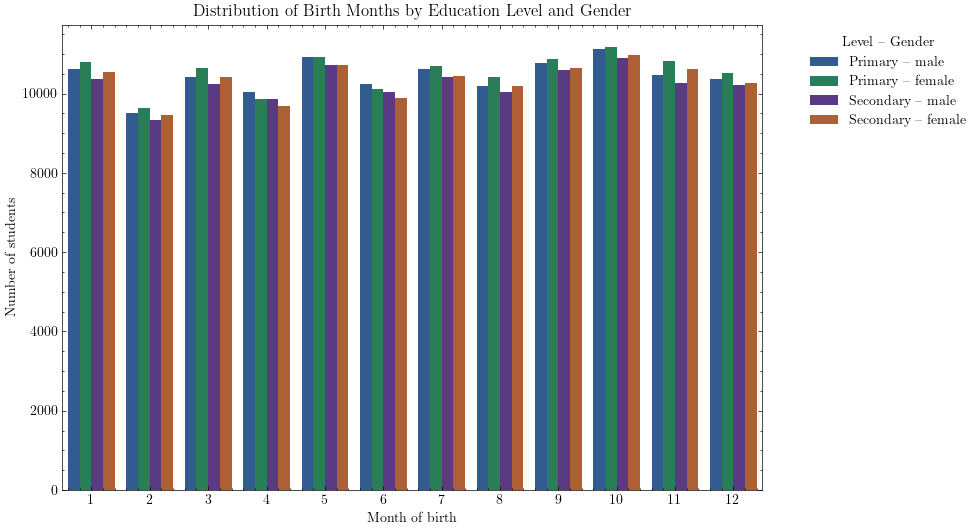

In [12]:
plt.style.use("itxaso.mplstyle")

# ===============================
# Plot 1 (gender): Birth months by level & gender (single plot)
# ===============================

# Unique students with month of birth and gender for each level
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting
df_birth = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order months 1..12
df_birth['MES_NAIXEMENT'] = pd.Categorical(
    df_birth['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Map numeric/letter gender codes to 'male'/'female'
gender_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}
df_birth['gender_key'] = df_birth['GENERE'].map(gender_map)

# Drop any rows with unmapped gender
df_birth = df_birth.dropna(subset=['gender_key'])

# Create combined level+gender category: e.g. "Primary – male", "Secondary – female"
df_birth['level_gender'] = (
    df_birth['snapshot'].astype(str) + ' – ' + df_birth['gender_key'].astype(str)
)

# Build a palette dict for the hue levels using your palette_gender['...']['...']['points']
level_gender_palette = {
    'Primary – male':     palette_gender['primary']['male']['points'],
    'Primary – female':   palette_gender['primary']['female']['points'],
    'Secondary – male':   palette_gender['secondary']['male']['points'],
    'Secondary – female': palette_gender['secondary']['female']['points'],
}

# Define hue order so bar groups are consistent across months
hue_order = [
    'Primary – male',
    'Primary – female',
    'Secondary – male',
    'Secondary – female'
]

plt.figure(figsize=(10, 5.5))
sns.countplot(
    data=df_birth,
    x='MES_NAIXEMENT',
    hue='level_gender',
    hue_order=hue_order,
    palette=level_gender_palette  # dict mapping hue level -> color
)  # [web:121][web:224][web:124]

plt.title('Distribution of Birth Months by Education Level and Gender')
plt.xlabel('Month of birth')
plt.ylabel('Number of students')
plt.legend(title='Level – Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3. Generalized

### Thermalization

In [ ]:
# --------------------------------------------------------
# 1. Thermalize one subject 
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
              already filtered to the subgroup (e.g. Primary + girls).
    grade_col: name of the grade column (string).

    Returns
    -------
    summary : DataFrame with month-level stats (months 1..12):
        month
        real_mean, real_std, real_n, real_sem
        null_mean, null_std, null_median
        q1, q3, iqr
        z_score, z_iqr
        band_min, band_max
        band_p16, band_p84
        band_p2_5, band_p97_5

    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df[grade_col] = pd.to_numeric(df[grade_col], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # --- Real stats per month (for error bars) ---
    real_grp = df.groupby('MES_NAIXEMENT')[grade_col]

    real_means = (
        real_grp.mean()
        .reindex(months, fill_value=np.nan)
    )
    real_std = (
        real_grp.std(ddof=1)      # sample SD of grades
        .reindex(months, fill_value=np.nan)
    )
    real_n = (
        real_grp.size()
        .reindex(months, fill_value=0)
        .astype(int)
    )

    # Standard error of the mean
    real_sem = real_std / np.sqrt(real_n.replace(0, np.nan))

    real_mean = real_means.values

    # --- Null distribution via month randomization ---
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # --- Null summaries ---
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-scores
    z     = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Full envelope
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    # ~68% central band
    band_p16, band_p84 = np.nanpercentile(sim, [16, 84], axis=0)

    # ~95% central band
    band_p2_5, band_p97_5 = np.nanpercentile(sim, [2.5, 97.5], axis=0)

    summary = pd.DataFrame({
        'month':     months,
        'real_mean': real_mean,
        'real_std':  real_std.values,
        'real_n':    real_n.values,
        'real_sem':  real_sem.values,
        'null_mean': null_mean,
        'null_std':  null_std,
        'null_median': null_med,
        'q1':        q1,
        'q3':        q3,
        'iqr':       iqr,
        'z_score':   z,
        'z_iqr':     z_iqr,
        'band_min':  band_min,
        'band_max':  band_max,
        'band_p16':  band_p16,
        'band_p84':  band_p84,
        'band_p2_5': band_p2_5,
        'band_p97_5': band_p97_5
    })

    return summary, sim


In [10]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# Distinct gender codes present in Primary
genders_P = sorted(df_P['GENERE'].dropna().unique())

# Map raw GENERE codes to 'male'/'female'
gender_key_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
primary_summaries_gender = {}   # dict: (subj, raw_gender_code) -> summary DataFrame
primary_sims_gender = {}        # dict: (subj, raw_gender_code) -> sim array
all_summaries = []

for subj in subjects_P:
    # Base dataframe for this subject in Primary
    base_df = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_P:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        # Map to 'male'/'female'; skip unknown codes
        gender_key = gender_key_map.get(gen, None)
        if gender_key not in ('male', 'female'):
            continue

        summary_P, sim_P = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_P['subject'] = subj
        summary_P['snapshot'] = 'Primary'
        summary_P['gender'] = gender_key   # normalized label

        primary_summaries_gender[(subj, gen)] = summary_P
        primary_sims_gender[(subj, gen)] = sim_P
        all_summaries.append(summary_P)

# Long-format dataset with all Primary stats by gender
# (includes real_sem, bands, z_score, z_iqr, etc. from thermalize_subject_by_month)
df_stats_primary_gender_all = pd.concat(all_summaries, ignore_index=True)


/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_36461/289273652.py:112: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


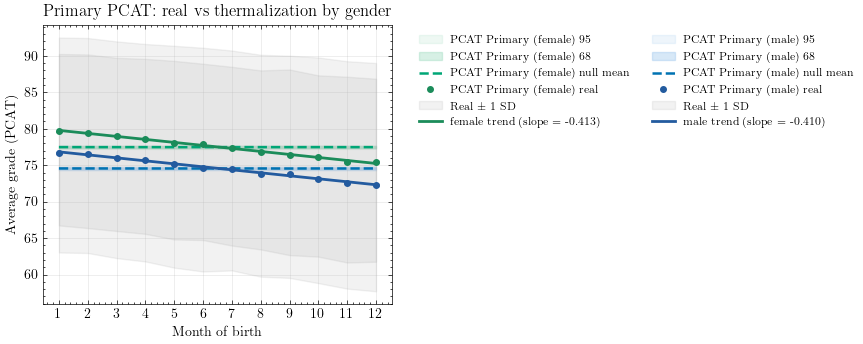

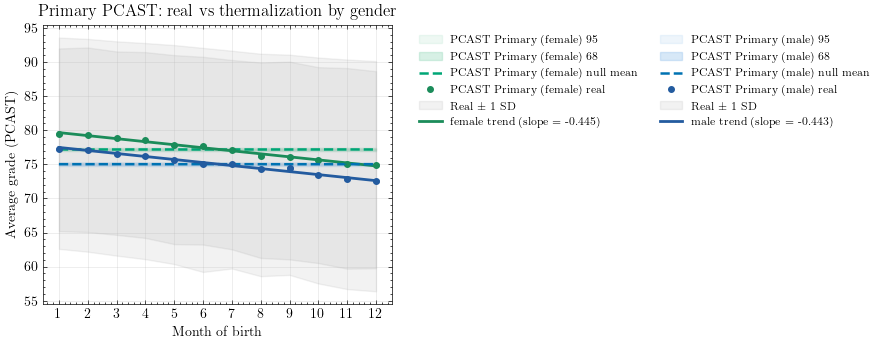

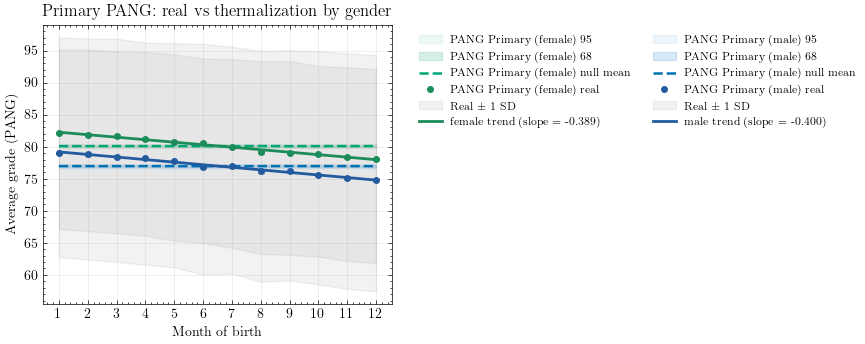

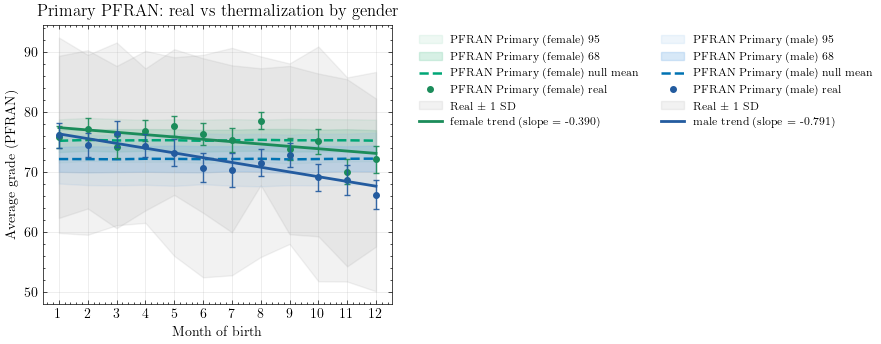

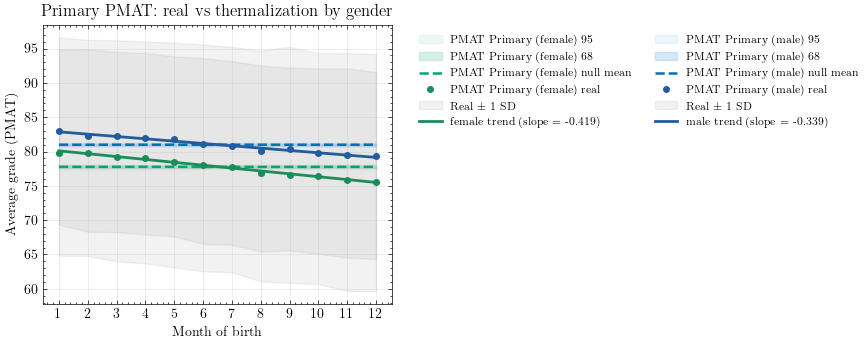

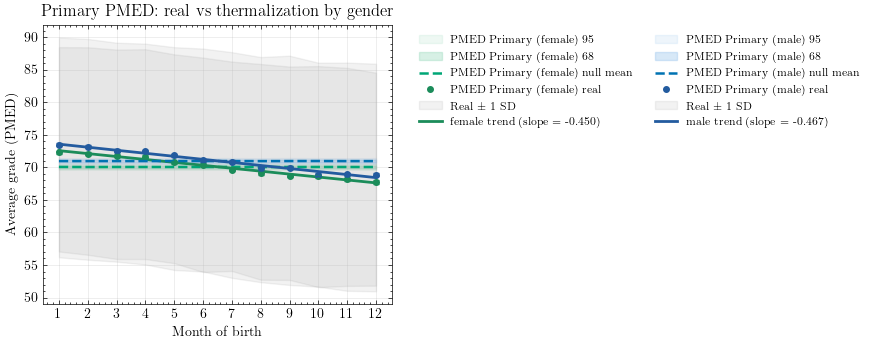

In [ ]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary, by gender)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_P:
    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    for gen in genders_P:
        key = (subj, gen)
        if key not in primary_summaries_gender:
            continue  # no data for this subject+gender

        summary_P = primary_summaries_gender[key]

        # Use normalized gender label from the summary
        gender_key = summary_P['gender'].iloc[0]  # 'male' or 'female'

        months     = summary_P['month'].values
        real_mean  = summary_P['real_mean'].values
        real_std   = summary_P['real_std'].values   # spread of grades per gender
        band_mean  = summary_P['null_mean'].values
        band_p16   = summary_P['band_p16'].values
        band_p84   = summary_P['band_p84'].values
        band_p2_5  = summary_P['band_p2_5'].values
        band_p97_5 = summary_P['band_p97_5'].values

        # Colors from your gender palette (PRIMARY)
        band_color  = palette_gender['primary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['primary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['primary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15,
            label=f'{subj} Primary ({gender_key}) 95% band'
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35,
            label=f'{subj} Primary ({gender_key}) 68% band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--', linewidth=1.8,
            color=mean_color,
            marker=None,
            label=f'{subj} Primary ({gender_key}) null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            label=f'{subj} Primary ({gender_key}) real'
        )
        
        real_sem = real_std / np.sqrt(summary_P['real_n'].values)
        # Error bars on real means: ± standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=f'{gender_key} trend (slope = {slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()

    filename = f"primary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


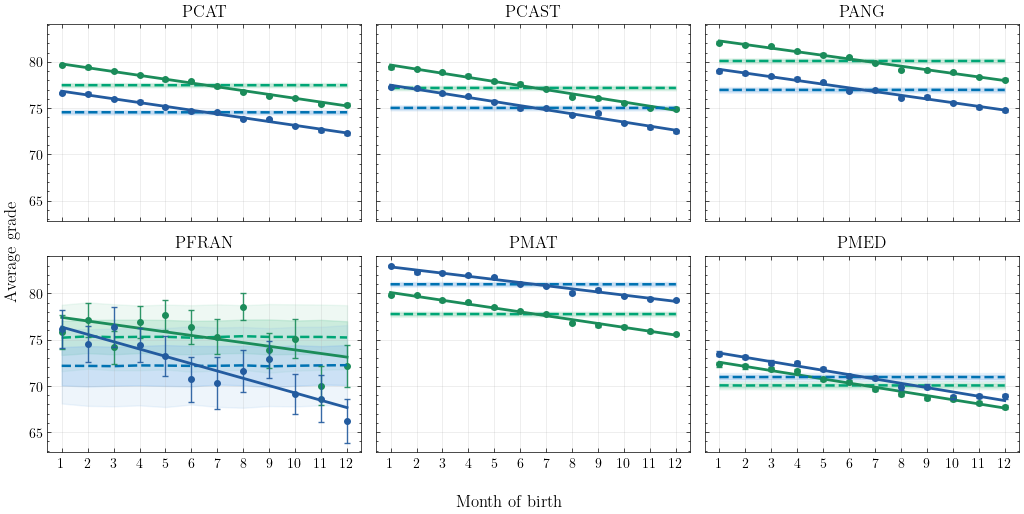

In [16]:
plt.style.use("itxaso.mplstyle")

#--------------------------
#   PRIMARY – MULTIPLOT BY GENDER
#--------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']

n_subj = len(subjects_P)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_P):
    # Loop over genders for this subject
    for gen in genders_P:
        key = (subj, gen)
        if key not in primary_summaries_gender:
            continue  # no data for this subject+gender

        summary_P = primary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_P['gender'].iloc[0]

        months     = summary_P['month'].values
        real_mean  = summary_P['real_mean'].values
        real_std   = summary_P['real_std'].values   # spread of grades
        band_mean  = summary_P['null_mean'].values
        band_p16   = summary_P['band_p16'].values
        band_p84   = summary_P['band_p84'].values
        band_p2_5  = summary_P['band_p2_5'].values
        band_p97_5 = summary_P['band_p97_5'].values

        # Colors from gender palette (PRIMARY)
        band_color  = palette_gender['primary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['primary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['primary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--', linewidth=1.8,
            color=mean_color,
            marker=None
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color
        )

        real_sem = real_std / np.sqrt(summary_P['real_n'].values)
        # Error bars on real means: ± standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None
            )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
for ax in (fig.axes):
    ax.tick_params(axis='x', which='minor', length=0)
fig.savefig(
    os.path.join(plot_dir, "primary_all_subjects_by_gender_multiplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()



In [11]:
# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS – by gender
# --------------------------------------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# Distinct gender codes present in Secondary
genders_S = sorted(df_S['GENERE'].dropna().unique())

# Map raw GENERE codes to 'male'/'female'
gender_key_map = {
    'h': 'male',
    'd': 'female',
    'H': 'male',
    'D': 'female'
}

# --------------------------------------------------------
# 2. Run analysis for all subjects, split by gender
# --------------------------------------------------------
secondary_summaries_gender = {}   # dict: (subj, raw_gender_code) -> summary DataFrame
secondary_sims_gender = {}        # dict: (subj, raw_gender_code) -> sim array
all_summaries = []

for subj in subjects_S:
    # Base dataframe for this subject in Secondary
    base_df = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'GENERE', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    for gen in genders_S:
        df_subj_gen = base_df[base_df['GENERE'] == gen].copy()

        # If no valid grades for this gender+subject, skip
        if df_subj_gen['GRADE'].dropna().empty:
            continue

        # Map to 'male'/'female'; skip unknown codes
        gender_key = gender_key_map.get(gen, None)
        if gender_key not in ('male', 'female'):
            continue

        summary_S, sim_S = thermalize_subject_by_month(
            df_level=df_subj_gen,
            grade_col='GRADE',
            n_iter=n_iter,
            seed=42  # can vary by subject/gender if desired
        )

        summary_S['subject'] = subj
        summary_S['snapshot'] = 'Secondary'
        summary_S['gender'] = gender_key   # normalized label

        secondary_summaries_gender[(subj, gen)] = summary_S
        secondary_sims_gender[(subj, gen)] = sim_S
        all_summaries.append(summary_S)

# Long-format dataset with all Secondary stats by gender
# (includes real_sem, band_p16/84, band_p2_5/97_5, z_score, z_iqr, etc.)
df_stats_secondary_gender_all = pd.concat(all_summaries, ignore_index=True) 


/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_29299/3895231946.py:104: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


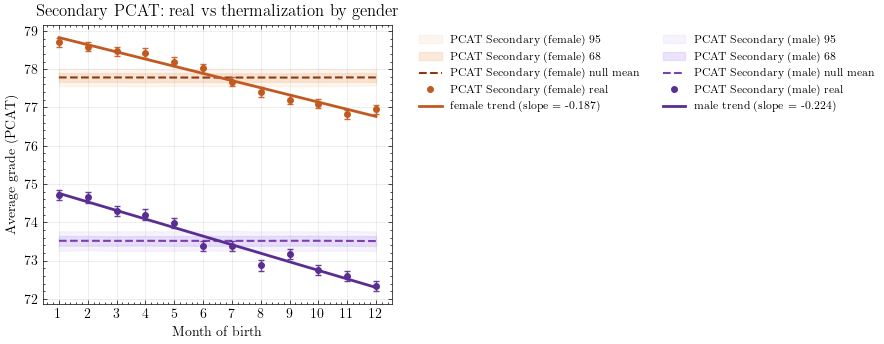

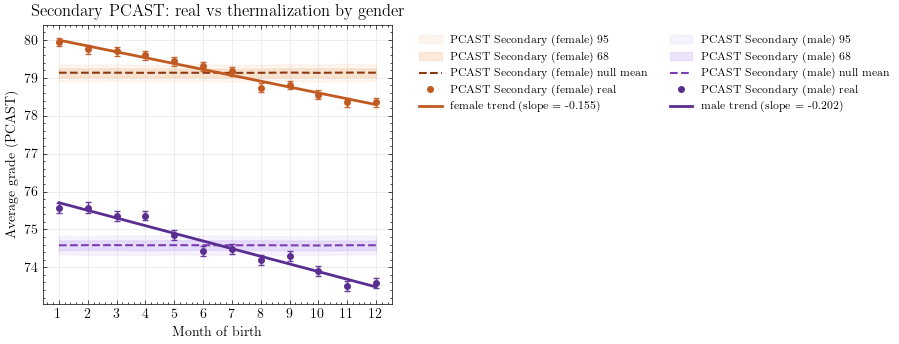

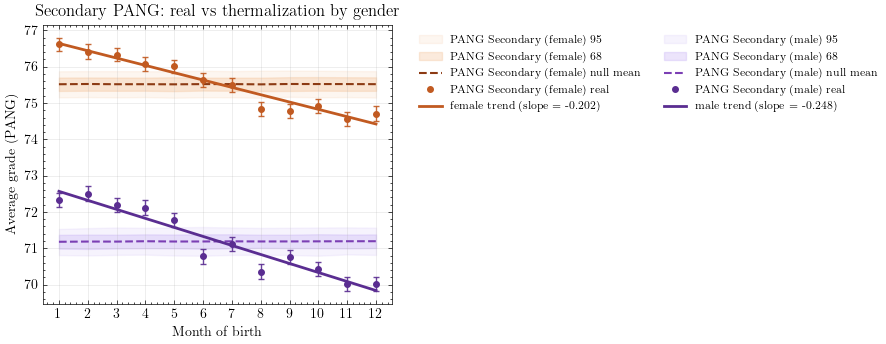

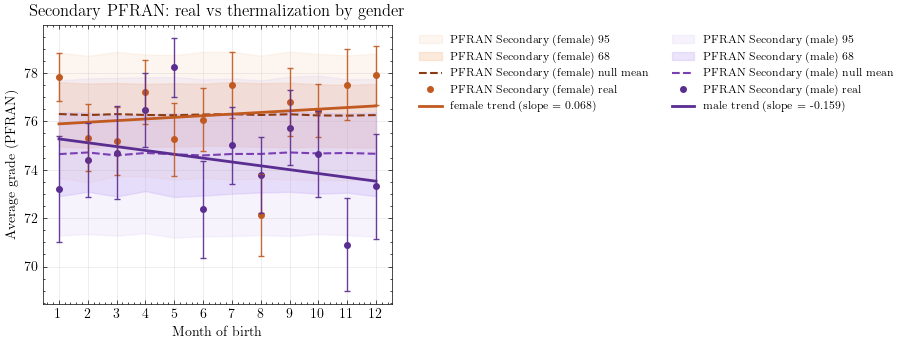

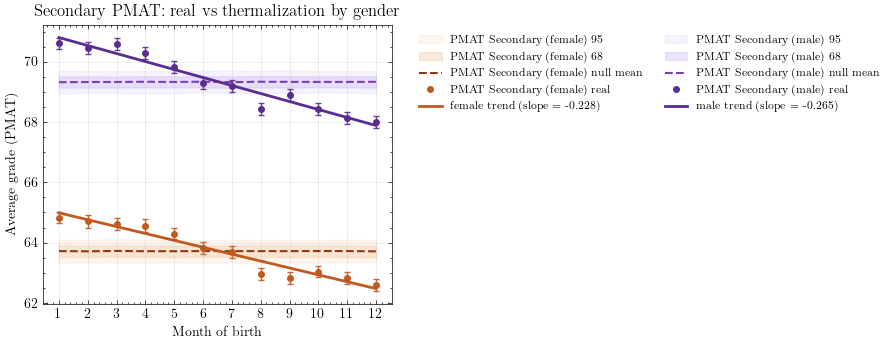

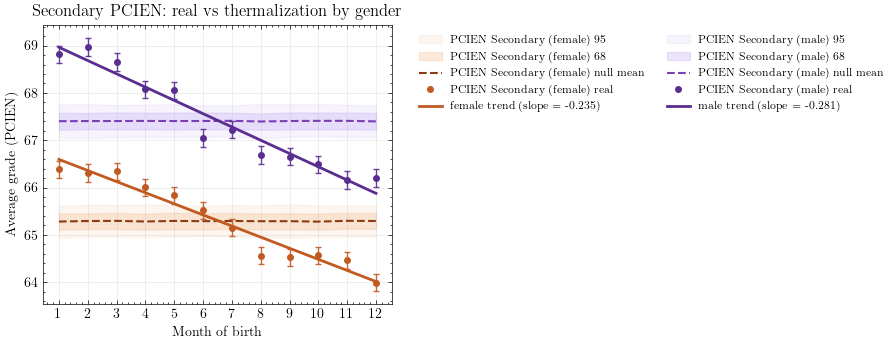

In [ ]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# Plot and save all subjects (Secondary, by gender)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_S:
    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    for gen in genders_S:
        key = (subj, gen)
        if key not in secondary_summaries_gender:
            continue  # no data for this subject+gender

        summary_S = secondary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_S['gender'].iloc[0]

        months     = summary_S['month'].values
        real_mean  = summary_S['real_mean'].values
        real_std   = summary_S['real_std'].values     # <-- spread of grades
        band_mean  = summary_S['null_mean'].values
        band_p16   = summary_S['band_p16'].values
        band_p84   = summary_S['band_p84'].values
        band_p2_5  = summary_S['band_p2_5'].values
        band_p97_5 = summary_S['band_p97_5'].values

        # Colors from your gender palette (SECONDARY)
        band_color  = palette_gender['secondary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['secondary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['secondary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15,
            label=f'{subj} Secondary ({gender_key}) 95% band'
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35,
            label=f'{subj} Secondary ({gender_key}) 68% band'
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--',
            linewidth=1.5,
            color=mean_color,
            marker=None,
            label=f'{subj} Secondary ({gender_key}) null mean'
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
            label=f'{subj} Secondary ({gender_key}) real'
        )

        real_sem = real_std / np.sqrt(summary_S['real_n'].values)
        # Error bars on real means: ± standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None,
                label=f'{gender_key} trend (slope = {slope:.3f})'
            )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization by gender')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    for ax in (fig.axes):
        ax.tick_params(axis='x', which='minor', length=0)

    filename = f"secondary_{subj}_by_gender_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


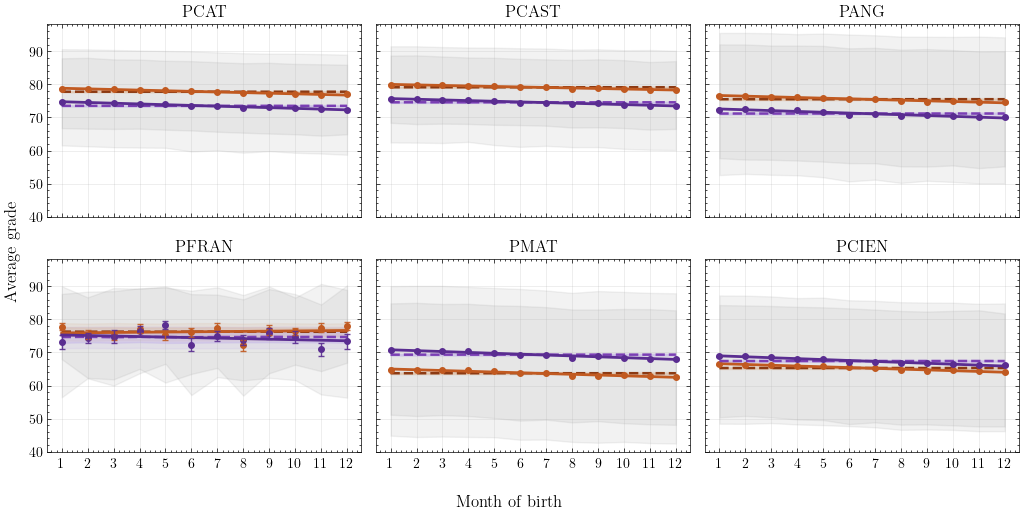

In [ ]:
plt.style.use("itxaso.mplstyle")

#--------------------------
#   SECONDARY – MULTIPLOT BY GENDER
#--------------------------

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

# SECONDARY MAIN SUBJECTS (PCIEN for science)
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

n_subj = len(subjects_S)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_S):
    # Loop over genders for this subject
    for gen in genders_S:
        key = (subj, gen)
        if key not in secondary_summaries_gender:
            continue  # no data for this subject+gender

        summary_S = secondary_summaries_gender[key]

        # Normalized gender label from summary ('male'/'female')
        gender_key = summary_S['gender'].iloc[0]

        months     = summary_S['month'].values
        real_mean  = summary_S['real_mean'].values
        real_std   = summary_S['real_std'].values    # <-- spread of grades
        band_mean  = summary_S['null_mean'].values
        band_p16   = summary_S['band_p16'].values
        band_p84   = summary_S['band_p84'].values
        band_p2_5  = summary_S['band_p2_5'].values
        band_p97_5 = summary_S['band_p97_5'].values

        # Colors from gender palette (SECONDARY)
        band_color  = palette_gender['secondary'][gender_key]['thermalized_band']
        mean_color  = palette_gender['secondary'][gender_key]['thermalized_mean_line']
        point_color = palette_gender['secondary'][gender_key]['points']

        # 95% null band (outer, light)
        ax.fill_between(
            months, band_p2_5, band_p97_5,
            color=band_color, alpha=0.15
        )

        # 68% null band (inner, darker)
        ax.fill_between(
            months, band_p16, band_p84,
            color=band_color, alpha=0.35
        )

        # Thermalized mean line
        ax.plot(
            months, band_mean,
            linestyle='--',
            linewidth=1.8,
            color=mean_color,
            marker=None
        )

        # Real mean points
        ax.plot(
            months, real_mean,
            marker='o',
            markersize=4,
            linestyle='None',
            color=point_color,
        )

        real_sem = real_std / np.sqrt(summary_S['real_n'].values)
        # Error bars on real means: ± standard deviation of grades
        ax.errorbar(
            months, real_mean,
            yerr=real_sem,
            fmt='none',
            ecolor=point_color,
            elinewidth=1.0,
            capsize=2,
            alpha=0.9,
            zorder=3
        )

        ax.fill_between(
            months,
            real_mean - real_std,
            real_mean + real_std,
            color='grey',    
            alpha=0.1,
            label='Real ± 1 SD'
        )

        # ----- Linear regression on real means -----
        mask = ~np.isnan(months) & ~np.isnan(real_mean)
        if mask.sum() >= 2:
            slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
            y_fit = intercept + slope * months

            ax.plot(
                months, y_fit,
                linewidth=2,
                linestyle='-',
                color=point_color,
                marker=None
            )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
for ax in (fig.axes):
    ax.tick_params(axis='x', which='minor', length=0)

fig.savefig(
    os.path.join(plot_dir, "secondary_all_subjects_by_gender_multiplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()



### Statistics

In [26]:
plt.style.use("itxaso.mplstyle")

cmap_icefire = sns.color_palette("coolwarm", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_summary_heatmaps_by_gender(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_gender_all or df_stats_secondary_gender_all
              must contain:
              subject, month, gender, z_score, real_mean, null_mean

    For each gender:
      Heatmap colors = Z-score (distance from null in sigmas).
      Cell annotations = grade difference (real_mean - null_mean), in points.
    """

    # Desired subject order, depending on level_label
    subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
    subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']

    # Loop over each gender present in this dataset
    for gender_key in sorted(df_stats['gender'].dropna().unique()):
        df = df_stats[df_stats['gender'] == gender_key].copy()
        if df.empty:
            continue

        # Ensure month is numeric and sorted
        df['month'] = pd.to_numeric(df['month'], errors='coerce')
        df = df.dropna(subset=['month'])

        # Sorted unique months
        months_sorted = sorted(df['month'].unique())

        # Subject order per level
        if level_label.lower().startswith("prim"):
            subject_order = subjects_P
        elif level_label.lower().startswith("sec"):
            subject_order = subjects_S
        else:
            subject_order = df['subject'].unique().tolist()

        # --- compute grade difference relative to null ("noise area") ---
        # delta_grade = real_mean - null_mean, in points
        df['delta_grade'] = df['real_mean'] - df['null_mean']

        # Pivot for colors: Z-scores
        z_pivot = (
            df.pivot_table(index='subject', columns='month', values='z_score')
              .reindex(index=subject_order)      # enforce subject order
              .reindex(columns=months_sorted)    # enforce month order
        )

        # Pivot for annotations: grade differences
        delta_pivot = (
            df.pivot_table(index='subject', columns='month', values='delta_grade')
              .reindex(index=subject_order)
              .reindex(columns=months_sorted)
        )

        # --- Z-score heatmap with grade-diff annotations ---
        fig, ax = plt.subplots(figsize=(6, 3.5))

        sns.heatmap(
            z_pivot,
            ax=ax,
            cmap=cmap_icefire,      # color encodes how many sigmas from null
            center=0,
            annot=delta_pivot,      # numbers shown = grade differences
            fmt='.2f',
            vmin=-22,
            vmax=22,
            cbar_kws={'label': 'Z-score (distance from null)'}
        )

        # Remove tick lines but keep labels
        ax.tick_params(axis='both', which='both', length=0)

        ax.set_title(
            f'{level_label} – Effect of birth month on grades ({gender_key})\n'
            '(color = Z-score, number = grade difference in points)'
        )
        ax.set_ylabel('Subject')
        ax.set_xlabel('Month of birth')

        # Force x tick labels to be 1, 2, 3, ...
        month_labels = [str(int(m)) for m in months_sorted]
        ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells
        ax.set_xticklabels(month_labels, rotation=0)

        fig.tight_layout()

        filename = f"{filename_prefix}_{gender_key}_zscore_heatmap.png"
        fig.savefig(os.path.join(plot_dir, filename), dpi=900, bbox_inches='tight')
        plt.show()


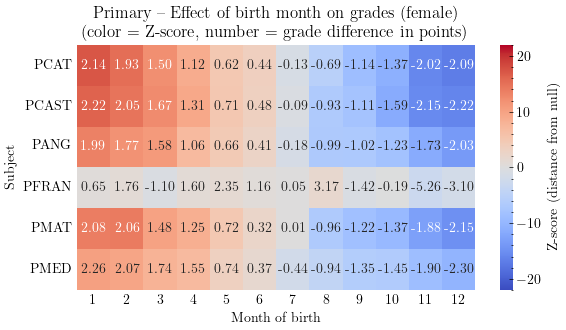

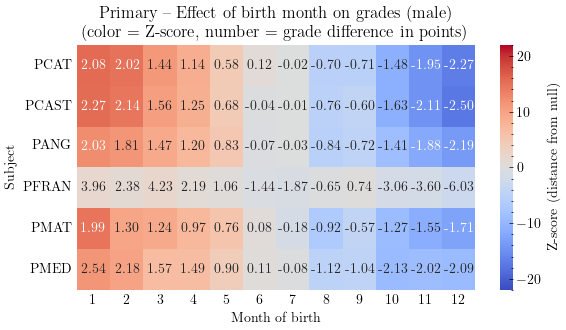

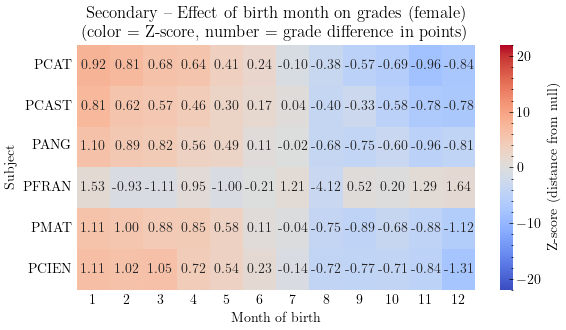

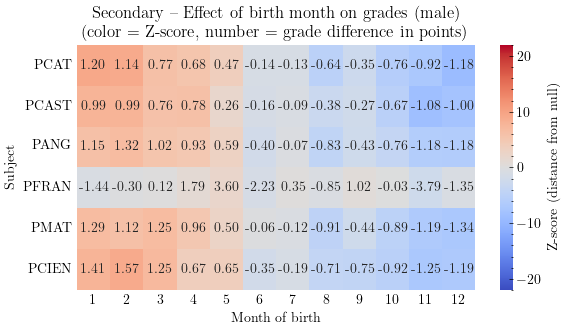

In [27]:
plot_summary_heatmaps_by_gender(df_stats_primary_gender_all,  'Primary',   'primary_gender')
plot_summary_heatmaps_by_gender(df_stats_secondary_gender_all, 'Secondary', 'secondary_gender')


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("itxaso.mplstyle")

cmap_gender_diff = sns.color_palette("coolwarm", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)


def plot_gender_difference_heatmap(df_stats_gender_all, level_label, filename_prefix):
    """
    Compare girls vs boys by subject and month for one level (Primary / Secondary).

    df_stats_gender_all: df_stats_primary_gender_all or df_stats_secondary_gender_all
        must contain:
        - subject, month, gender ('male'/'female'), z_score, real_mean, null_mean

    For each subject x month:
      color = z_female - z_male            (difference in distance from null)
      number = (Δgrade_female - Δgrade_male), in grade points
    """

    # Copy and ensure numeric month
    df = df_stats_gender_all.copy()
    df["month"] = pd.to_numeric(df["month"], errors="coerce")
    df = df.dropna(subset=["month"])

    # Restrict to male/female if there were any other codes
    df = df[df["gender"].isin(["male", "female"])]

    # Desired subject order
    subjects_P = ["PCAT", "PCAST", "PANG", "PFRAN", "PMAT", "PMED"]
    subjects_S = ["PCAT", "PCAST", "PANG", "PFRAN", "PMAT", "PCIEN"]

    if level_label.lower().startswith("prim"):
        subject_order = subjects_P
    elif level_label.lower().startswith("sec"):
        subject_order = subjects_S
    else:
        subject_order = sorted(df["subject"].unique().tolist())

    # Sorted months
    months_sorted = sorted(df["month"].unique())

    # Compute Δgrade = real_mean - null_mean for each gender
    df["delta_grade"] = df["real_mean"] - df["null_mean"]

    # Split by gender
    df_m = df[df["gender"] == "male"]
    df_f = df[df["gender"] == "female"]

    # Pivot z-scores
    z_m = (
        df_m.pivot_table(index="subject", columns="month", values="z_score")
            .reindex(index=subject_order, columns=months_sorted)
    )
    z_f = (
        df_f.pivot_table(index="subject", columns="month", values="z_score")
            .reindex(index=subject_order, columns=months_sorted)
    )

    # Pivot Δgrade
    d_m = (
        df_m.pivot_table(index="subject", columns="month", values="delta_grade")
            .reindex(index=subject_order, columns=months_sorted)
    )
    d_f = (
        df_f.pivot_table(index="subject", columns="month", values="delta_grade")
            .reindex(index=subject_order, columns=months_sorted)
    )

    # Differences (female - male)
    z_diff = z_f - z_m
    delta_diff = d_f - d_m

    # Symmetric color scale
    diff_abs_max = np.nanmax(np.abs(z_diff.values))
    vmin, vmax = -diff_abs_max, diff_abs_max

    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_diff,
        ax=ax,
        cmap=cmap_gender_diff,   # coolwarm
        vmin=-22,
        vmax=22,
        center=0,
        annot=delta_diff,        # show grade difference (girls - boys)
        fmt=".2f",
        cbar_kws={"label": "Female - male z-score"}
    )

    ax.tick_params(axis="both", which="both", length=0)

    # Optional: label PMED/PCIEN equivalence for Secondary
    if level_label.lower().startswith("sec"):
        ytick_labels = ["PCAT", "PCAST", "PANG", "PFRAN", "PMAT", "PCIEN"]
        ax.set_yticklabels(ytick_labels, rotation=0)

    ax.set_title(
        f"{level_label} – Gender difference by subject and month\n"
        "(color = female - male z-score; number = grade diff in points)"
    )
    ax.set_ylabel("Subject")
    ax.set_xlabel("Month of birth")

    # Month labels centered on cells
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)
    ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    fname = f"{filename_prefix}_gender_difference_heatmap.png"
    fig.savefig(os.path.join(plot_dir, fname), dpi=900, bbox_inches="tight")
    plt.show()


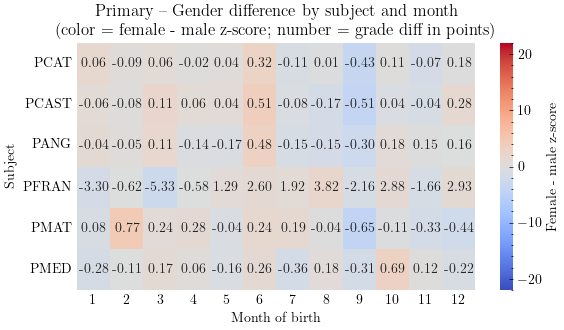

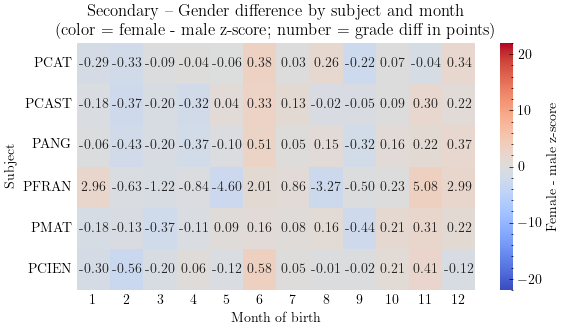

In [15]:
plot_gender_difference_heatmap(
    df_stats_primary_gender_all,  "Primary",   "primary"
)
plot_gender_difference_heatmap(
    df_stats_secondary_gender_all, "Secondary", "secondary"
)


In [22]:
%store df_stats_primary_gender_all

Stored 'df_stats_primary_gender_all' (DataFrame)


In [21]:
%store -r df_stats_primary_all


In [44]:
plt.style.use("itxaso.mplstyle")
cmap_icefire = sns.color_palette("icefire", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_zscore_diff_sec_minus_prim_by_gender(
    df_stats_primary_gender_all,
    df_stats_secondary_gender_all
):
    """
    For each gender ('male','female'):
      - align Primary and Secondary z-scores by subject+month
      - compute z_diff = z_secondary - z_primary
      - plot a heatmap (subjects × months) of z_diff.
    """

    # Map Secondary PCIEN -> PMED so subjects align
    subj_map_S_to_P = {'PCIEN': 'PMED'}

    # work on copies
    dfP_all = df_stats_primary_gender_all.copy()
    dfS_all = df_stats_secondary_gender_all.copy()
    dfS_all['subject'] = dfS_all['subject'].replace(subj_map_S_to_P)

    for gender_key in ['male', 'female']:
        dfP = dfP_all[dfP_all['gender'] == gender_key].copy()
        dfS = dfS_all[dfS_all['gender'] == gender_key].copy()
        if dfP.empty or dfS.empty:
            continue

        # numeric months
        dfP['month'] = pd.to_numeric(dfP['month'], errors='coerce')
        dfS['month'] = pd.to_numeric(dfS['month'], errors='coerce')
        dfP = dfP.dropna(subset=['month'])
        dfS = dfS.dropna(subset=['month'])

        # common grid of months & subjects
        months_sorted = sorted(set(dfP['month'].unique()) | set(dfS['month'].unique()))
        subjects_sorted = sorted(set(dfP['subject'].unique()) | set(dfS['subject'].unique()))

        # pivot to subject × month matrices
        zP = (
            dfP.pivot_table(index='subject', columns='month', values='z_score')
               .reindex(index=subjects_sorted, columns=months_sorted)
        )  [web:286][web:292]

        zS = (
            dfS.pivot_table(index='subject', columns='month', values='z_score')
               .reindex(index=subjects_sorted, columns=months_sorted)
        )  [web:286][web:292]

        # difference matrix: Secondary − Primary
        z_diff = zS - zP  # elementwise difference[web:228]

        # symmetric color scale around 0
        diff_abs_max = np.nanmax(np.abs(z_diff.values))
        vmin, vmax = -diff_abs_max, diff_abs_max

        fig, ax = plt.subplots(figsize=(6, 3.5))

        sns.heatmap(
            z_diff,
            ax=ax,
            cmap=cmap_icefire,
            vmin=vmin,
            vmax=vmax,
            center=0,
            annot=True,
            fmt='.1f',
            cbar_kws={'label': 'Secondary − Primary z-score'}
        )  [web:229][web:357]

        ax.set_title(f'Secondary − Primary z (gender = {gender_key})')
        ax.set_ylabel('Subject')
        ax.set_xlabel('Month of birth')

        # x tick labels 1..12 centered on cells
        month_labels = [str(int(m)) for m in months_sorted]
        ax.set_xticks(np.arange(len(months_sorted)) + 0.5)
        ax.set_xticklabels(month_labels, rotation=0)

        fig.tight_layout()

        fname = f"zdiff_sec_minus_prim_{gender_key}_heatmap.png"
        fig.savefig(os.path.join(plot_dir, fname), dpi=300, bbox_inches='tight')
        plt.show()


In [ ]:
plot_zscore_diff_sec_minus_prim_by_gender(
    df_stats_primary_gender_all,
    df_stats_secondary_gender_all
)



NameError: name 'web' is not defined

In [47]:
def plot_z_relationship_primary_secondary_by_gender(
    df_stats_primary_gender_all,
    df_stats_secondary_gender_all
):
    """
    Build a scatter plot of z_secondary vs z_primary,
    colored by gender, across all subjects and months.
    """

    subj_map_S_to_P = {'PCIEN': 'PMED'}

    dfP = df_stats_primary_gender_all.copy()
    dfS = df_stats_secondary_gender_all.copy()
    dfS['subject'] = dfS['subject'].replace(subj_map_S_to_P)

    # Keep only needed columns
    dfP_small = dfP[['subject', 'month', 'gender', 'z_score']].rename(
        columns={'z_score': 'z_primary'}
    )
    dfS_small = dfS[['subject', 'month', 'gender', 'z_score']].rename(
        columns={'z_score': 'z_secondary'}
    )

    # Align on subject, month, gender
    df_merge = pd.merge(
        dfP_small,
        dfS_small,
        on=['subject', 'month', 'gender'],
        how='inner'
    )

    # numeric months (if not already)
    df_merge['month'] = pd.to_numeric(df_merge['month'], errors='coerce')
    df_merge = df_merge.dropna(subset=['month'])

    plt.style.use("itxaso.mplstyle")
    plt.figure(figsize=(6, 6))

    sns.scatterplot(
        data=df_merge,
        x='z_primary',
        y='z_secondary',
        hue='gender',
        style='gender',
        alpha=0.7
    )

    # diagonal reference line y = x
    lim = max(
        np.nanmax(np.abs(df_merge['z_primary'].values)),
        np.nanmax(np.abs(df_merge['z_secondary'].values))
    )
    lim = max(lim, 1)
    plt.plot([-lim, lim], [-lim, lim], color='gray', linestyle='--', linewidth=1)

    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel('Primary z-score')
    plt.ylabel('Secondary z-score')
    plt.title('Primary vs Secondary z-scores by gender\n(each point = subject–month)')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    fname = "z_relationship_primary_vs_secondary_by_gender_scatter.png"
    plt.savefig(os.path.join(plot_dir, fname), dpi=300, bbox_inches='tight')
    plt.show()


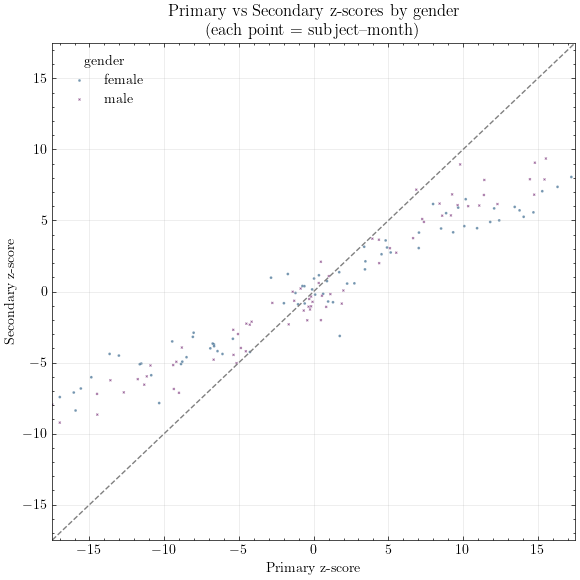

In [48]:
plot_z_relationship_primary_secondary_by_gender(
    df_stats_primary_gender_all,
    df_stats_secondary_gender_all
)


In [49]:
! pip install networkx

In [54]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("itxaso.mplstyle")

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

def chord_subject_gender(
    df_stats_primary_gender_all,
    df_stats_secondary_gender_all,
    subject,
    level="Primary"
):
    """
    Circular chord-like plot for one subject and level,
    showing z-scores by gender and month.

    Nodes:
      - 'male', 'female'
      - 'M1'..'M12'  (months)

    Edge from gender -> month with width ∝ |z_score|
    and color depending on sign and gender.
    """

    # Choose right table
    if level.lower().startswith("prim"):
        df = df_stats_primary_gender_all.copy()
    else:
        df = df_stats_secondary_gender_all.copy()

    # Filter this subject & level
    df_subj = df[(df['subject'] == subject) & (df['snapshot'] == level)].copy()
    if df_subj.empty:
        print(f"No data for {level} {subject}")
        return

    # Ensure numeric months
    df_subj['month'] = pd.to_numeric(df_subj['month'], errors='coerce')
    df_subj = df_subj.dropna(subset=['month'])

    # Limit to the two main genders, if present
    df_subj = df_subj[df_subj['gender'].isin(['male', 'female'])]
    if df_subj.empty:
        print(f"No male/female data for {level} {subject}")
        return

    # Build graph
    G = nx.Graph()

    # Gender nodes
    gender_nodes = sorted(df_subj['gender'].unique())
    for g in gender_nodes:
        G.add_node(g, kind='gender')

    # Month nodes
    months = sorted(df_subj['month'].unique())
    month_nodes = [f"M{int(m)}" for m in months]
    for mnode in month_nodes:
        G.add_node(mnode, kind='month')

    # Add edges: gender -> month with z-score weight
    for _, row in df_subj.iterrows():
        g = row['gender']
        m = int(row['month'])
        z = row['z_score']

        if np.isnan(z):
            continue

        mnode = f"M{m}"
        if g not in G or mnode not in G:
            continue

        strength = abs(z)
        strength_clipped = min(strength, 6.0)

        # Color: sign + gender
        if z >= 0:
            # positive: birth month where this gender does better than null
            edge_color = palette_gender[level.lower()][g]['points']
        else:
            # negative: worse than null -> desaturate / grayish
            edge_color = "#777777"

        G.add_edge(
            g, mnode,
            weight=strength_clipped,
            z=z,
            color=edge_color
        )

    # Arrange nodes in a circle: genders together, then months
    # Manually set order to control placement
    ordered_nodes = gender_nodes + month_nodes
    pos = nx.circular_layout(G)
    # Re-map layout to follow our order around the circle
    angles = np.linspace(0, 2*np.pi, len(ordered_nodes)+1)[:-1]
    for node, theta in zip(ordered_nodes, angles):
        pos[node] = np.array([np.cos(theta), np.sin(theta)])

    # Extract edge styling
    edges = G.edges(data=True)
    edge_colors = [e[2]['color'] for e in edges]
    edge_widths = [0.5 + 1.2 * e[2]['weight'] for e in edges]

    # Node colors: gender vs month
    node_colors = []
    for node in G.nodes():
        kind = G.nodes[node]['kind']
        if kind == 'gender':
            if node == 'male':
                node_colors.append(palette_gender[level.lower()]['male']['points'])
            else:
                node_colors.append(palette_gender[level.lower()]['female']['points'])
        else:
            node_colors.append("#cccccc")

    fig, ax = plt.subplots(figsize=(6, 6))

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=700,
        node_color=node_colors,
        ax=ax
    )

    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.8,
        ax=ax
    )

    nx.draw_networkx_labels(
        G,
        pos,
        font_size=8,
        ax=ax
    )

    ax.set_title(f"{level} {subject} – gender × month z-scores (chord view)")
    ax.set_axis_off()
    fig.tight_layout()

    fname = f"chord_{level.lower()}_{subject}_gender_month.png"
    fig.savefig(os.path.join(plot_dir, fname), dpi=300, bbox_inches='tight')
    plt.show()


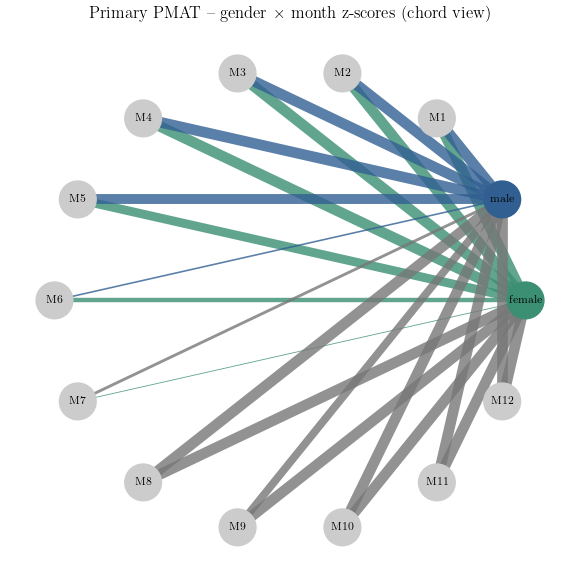

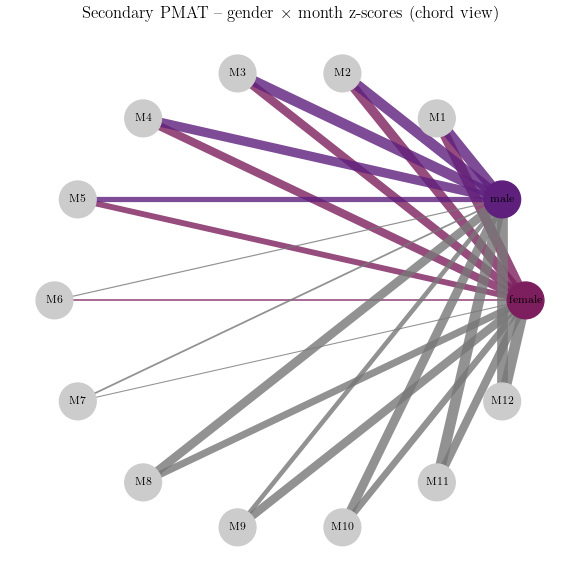

In [55]:
chord_subject_gender(df_stats_primary_gender_all, df_stats_secondary_gender_all,
                     subject="PMAT", level="Primary")

chord_subject_gender(df_stats_primary_gender_all, df_stats_secondary_gender_all,
                     subject="PMAT", level="Secondary")
